<a href="https://colab.research.google.com/github/0731325603/regression-predict-api-template/blob/master/team_5_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **EXPLORE Data Science Academy Regression Sprint**




### **Sendy Logistics Challenge**:

Data is a critical component in helping Sendy to build more efficient, affordable and accessible solutions. Given the details of a Sendy order, use the historic data to predict an accurate time for the arrival of the rider at the destination of a package. In this competition, we’re challenging you to build a model that predicts an accurate delivery time, from picking up a package to arriving at the final destination. An accurate arrival time prediction will help all businesses to improve their logistics and communicate an accurate time to their customers.

## **Problem statement**:

*  Build a model to predict the estimated time of delivery of orders, from the point of driver pickup to the point of arrival at final destination.



## **Problem Landscape**:

>  *  Data:
>  
>  *  Information:
>
>  *  Knowledge:

## **Imports**:

In [0]:
# import libraries
from google.colab import files
import numpy as np
import pandas as pd
import seaborn as sns
import datetime
import matplotlib.pyplot as plt

# import machine learning libraries
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from skopt import BayesSearchCV


## **Data Loading**:

**Data files:**

*  Train.csv - is the dataset that you will use to train your model.
*  Test.csv - is the dataset on which you will apply your model to.
*  Riders.csv - contains unique rider Ids, number of orders, age, rating and number of ratings

**Variables**

1.  **Order details**
>*  Order No – Unique number identifying the order
>*  User Id – Unique number identifying the customer on a platform
>*  Vehicle Type – For this competition limited to bikes, however in practice, Sendy service extends to trucks and vans
>*  Platform Type – Platform used to place the order, there are 4 types
>*  Personal or Business – Customer type

2.  **Placement times**
>*  Placement - Day of Month i.e 1-31
>*  Placement - Weekday (Monday = 1)
>*  Placement - Time - Time of day the order was placed

3.  **Confirmation times**
>*Confirmation - Day of Month i.e 1-31
>*Confirmation - Weekday (Monday = 1)
>*Confirmation - Time - time of day the order was confirmed by a rider

4.  **Arrival at Pickup times**
>*  Arrival at Pickup - Day of Month i.e 1-31
>*  Arrival at Pickup - Weekday (Monday = 1)
>*  Arrival at Pickup - Time - Time of day the rider arrived at the location to pick up the order - as marked by the rider through the Sendy application

5.  **Pickup times**
>*  Pickup - Day of Month i.e 1-31
>*  Pickup - Weekday (Monday = 1)
>*  Pickup - Time - Time of day the rider picked up the order - as marked by the rider through the Sendy application

6.  **Arrival at Destination times** (column missing in Test set)
>*  Arrival at Delivery - Day of Month i.e 1-31
>*  Arrival at Delivery - Weekday (Monday = 1)
>*  Arrival at Delivery - Time - Time of day the rider arrived at the destination to deliver the order - as marked by the rider through the Sendy application
>*  Distance covered (KM) - The distance from Pickup to Destination
>*  Temperature -Temperature at the time of order placement in Degrees Celsius (measured every three hours)
>*  Precipitation in Millimeters - Precipitation at the time of order placement (measured every three hours)
>*  Pickup Latitude and Longitude - Latitude and longitude of pick up location
>*  Destination Latitude and Longitude - Latitude and longitude of delivery location
>*  Rider ID – ID of the Rider who accepted the order
>*  Time from Pickup to Arrival - Time in seconds between ‘Pickup’ and ‘Arrival at Destination’ - calculated from the columns for the purpose of facilitating the task

7.  **Rider metrics**
>*  Rider ID – Unique number identifying the rider (same as in order details)
>*  No of Orders – Number of Orders the rider has delivered
>*  Age – Number of days since the rider delivered the first order
>*  Average Rating – Average rating of the rider
>*  No of Ratings - Number of ratings the rider has received. Rating an order is optional for the customer.

In [0]:
# load data from csv files 
train_data = pd.read_csv('https://raw.githubusercontent.com/0731325603/regression-predict-api-template/master/Data/Train.csv')
test_data = pd.read_csv('https://raw.githubusercontent.com/0731325603/regression-predict-api-template/master/Data/Test.csv')
rider_data = pd.read_csv('https://raw.githubusercontent.com/0731325603/regression-predict-api-template/master/Data/Riders.csv')
samplesubmission = pd.read_csv('https://raw.githubusercontent.com/0731325603/regression-predict-api-template/master/Data/SampleSubmission.csv')


In [0]:
# view top 5 rows of train_data
train_data.head()


In [0]:
# view top 5 rows of test_data
test_data.head()


In [0]:
# view top 5 rows of rider_data
rider_data.head()


## **Functions**:

In [0]:
# investigate unique values in a given column
def total_unique_values(df, column_name):
  """Return unique values on the each column."""
  return len(np.unique(df[column_name]))

# delete outliers in a given column
# Ref: https://datascience.stackexchange.com/questions/33632/remove-local-outliers-from-dataframe-using-pandas
def remove_outlier(df, column_name):
    q1 = df[column_name].quantile(0.25)
    q3 = df[column_name].quantile(0.75)
    iqr = q3 - q1
    fence_low  = q1 - 1.5 * iqr
    fence_high = q3 + 1.5 * iqr
    return df.loc[(df[column_name] > fence_low) & (df[column_name] < fence_high)]
    
# investigate missing columns between 2 dataframes
def total_missing_columns(df1, df2):
  return [col for col in df1.columns if col in df1.columns and col not in df2.columns]

# slit string time into Hours, Min, Sec and return dataframe containing such
def split_str_time(df, column_name):
  h = []
  m = []
  s = []
  x = []
  for time in df[column_name]:
    time_str1 = time.split(" ")
    time_str2 = time_str1[0].split(":")
    h.append(int(time_str2[0]))
    m.append(int(time_str2[1]))
    s.append(int(time_str2[2]))
    x.append(time_str1[1])

  my_dict = {'Hour':h, 'Min':m, 'Sec':s, 'AM_PM':x}
  new_df = pd.DataFrame(my_dict)
  new_df[column_name] = df[column_name]
  return new_df


## **Data Preprocessing**:

### **Exploratory Data Analysis**:

### **Explore relationships**

*   Find relationships between tables.



In [0]:
# print the shapes of the dastaframes
print("Train data: {}".format(train_data.shape))
print("Test data: {}".format(test_data.shape))
print("Rider data: {}".format(rider_data.shape))


In [0]:
# print the column names of the dastaframes
print("Train data:\n{}".format(train_data.columns))
print("\nTest data:\n{}".format(test_data.columns))
print("\nRider data:\n{}".format(rider_data.columns))


**Notes and Insights**:

*   All dataframes have 'Rider Id' column, join rider_data to both train and test dataframes.
*   Train and Test data differs by 4 columns.



In [0]:
# join 'rider_data' to both train and test on 'Rider Id' column
train_df = pd.merge(train_data, rider_data, on = 'Rider Id')
test_df = pd.merge(test_data, rider_data, on = 'Rider Id')

# print the shapes of the dastaframes
print("Train data: {}".format(train_df.shape))
print("Test data: {}".format(test_df.shape))


In [0]:
# investigate missing columns
total_missing_columns(train_df, test_df)


In [0]:
# drop missing columns
train_df = train_df.drop(['Arrival at Destination - Day of Month', 'Arrival at Destination - Weekday (Mo = 1)', 'Arrival at Destination - Time'], axis=1)

# print the shapes of the dastaframes
print("Train data: {}".format(train_df.shape))
print("Test data: {}".format(test_df.shape))


### **Missing Values**:

In [0]:
# investigate missing values
train_df.isnull().sum()


In [0]:
# investigate unique values in each columns
for col in train_df.columns:
  print('The number of unique values in {} :{}'.format(col, total_unique_values(train_df, col)))


In [0]:
# drop the 'Vehicle Type' column
train_df = train_df.drop(['Vehicle Type'], axis = 1)


In [0]:
# drop the Precipitation column
train_df = train_df.drop(['Precipitation in millimeters'], axis = 1)


In [0]:
# investigate the summary statistics of the Temperature column
train_df['Temperature'].describe()


In [0]:
# delete ourliers based on the Temperature column
train_df = remove_outlier(train_df, 'Temperature')


In [0]:
# fill missing values with the mean in the Temperature column
train_df['Temperature'].fillna((train_df['Temperature'].mean()), inplace = True)


In [0]:
# investigate missing values
train_df.isnull().sum()


In [0]:
# view columns
train_df.columns


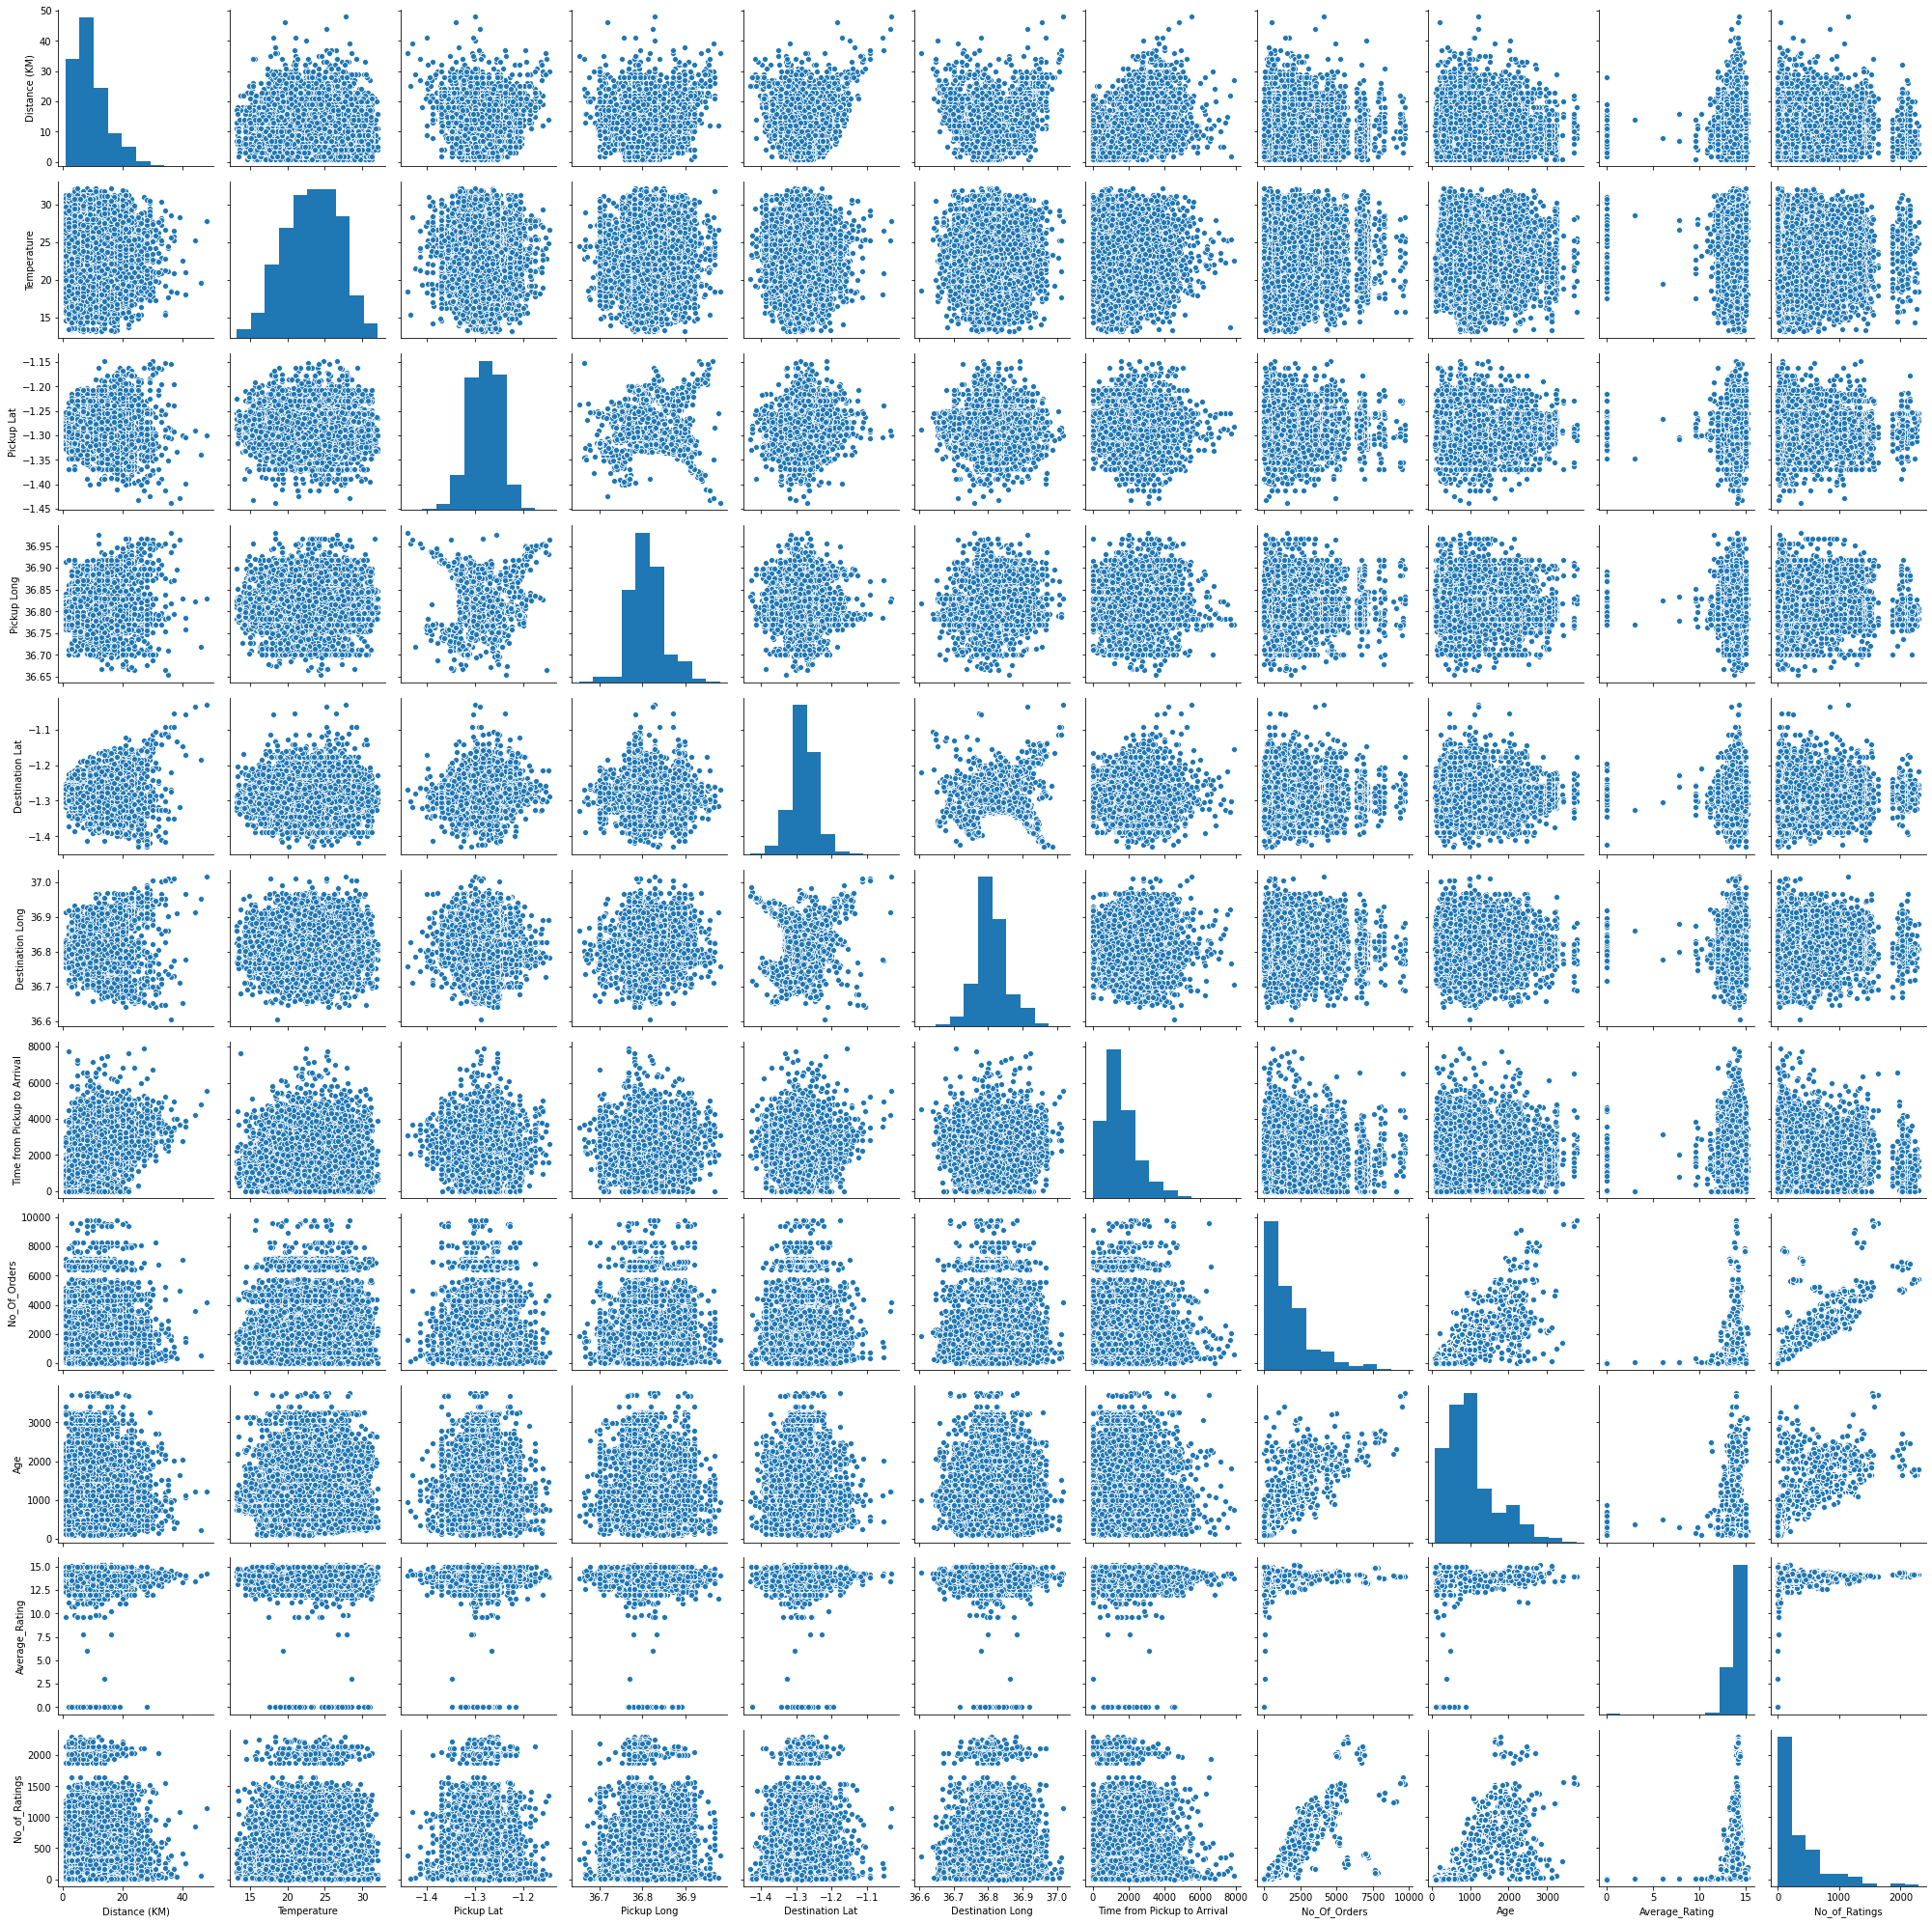

In [64]:
# visualising a subset of the data
g = sns.pairplot(train_df[['Distance (KM)', 'Temperature', 'Pickup Lat', 'Pickup Long',
       'Destination Lat', 'Destination Long',
       'Time from Pickup to Arrival', 'No_Of_Orders', 'Age', 'Average_Rating',
       'No_of_Ratings']])


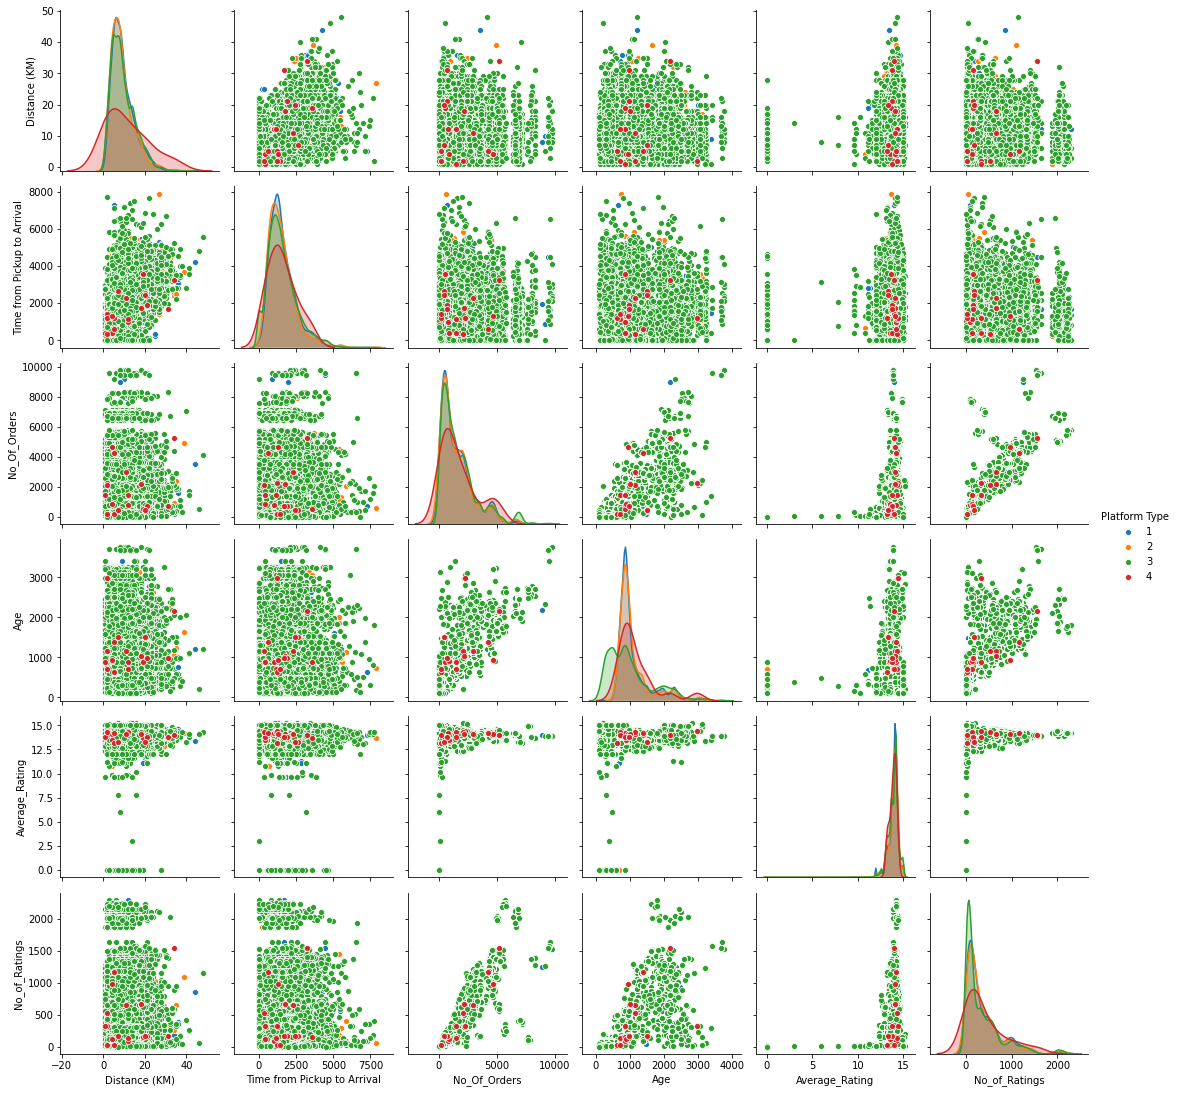

In [65]:
# visualising a subset of the data
g = sns.pairplot(train_df[['Distance (KM)', 'Time from Pickup to Arrival', 'No_Of_Orders', 'Age', 
                           'Average_Rating', 'No_of_Ratings', 'Platform Type']], hue='Platform Type')


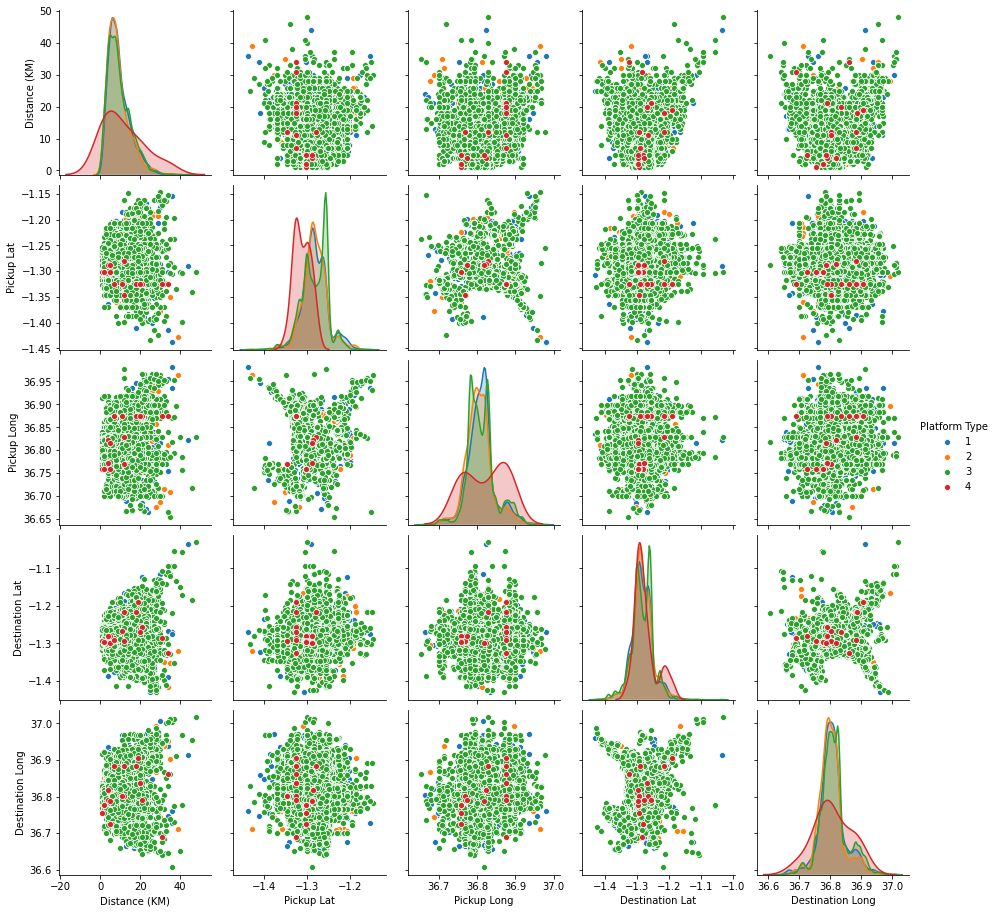

In [66]:
# visualising a subset of the data
g = sns.pairplot(train_df[['Distance (KM)', 'Pickup Lat', 'Pickup Long',
       'Destination Lat', 'Destination Long', 'Platform Type']], hue='Platform Type')


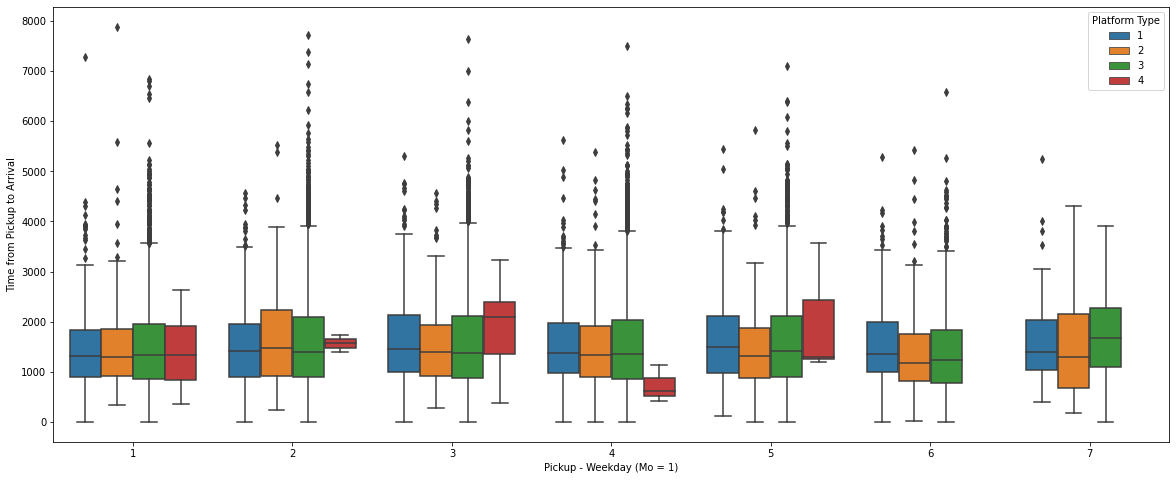

In [67]:
# investigate the distribution by categorical variables
plt.figure(figsize = (20, 8))
g = sns.boxplot(x = 'Pickup - Weekday (Mo = 1)', y = 'Time from Pickup to Arrival', data = train_df, hue = 'Platform Type')


**Notes and Insights**:


*   Platform 4 is available from Monday to Friday, on weekends it's not actively used.During weekdays when compared to the other platforms tend to find that it avarage almost match with other platform except on Thursday.
*   Platform 3 is the most dominating platform with outliers.



## **Data Cleaning**:

In [68]:
# selecting usefull columns only
train_df = train_df.drop(['Order No', 'User Id', 'Placement - Day of Month',
       'Placement - Weekday (Mo = 1)', 'Placement - Time',
       'Confirmation - Day of Month', 'Confirmation - Weekday (Mo = 1)',
       'Confirmation - Time', 'Arrival at Pickup - Day of Month',
       'Arrival at Pickup - Weekday (Mo = 1)', 'Arrival at Pickup - Time', 'Rider Id'], axis=1)

# visualize the train data
train_df.head()


Platform Type Personal or Business  ...  Average_Rating  No_of_Ratings
0              3             Business  ...            13.8            549
1              3             Personal  ...            13.8            549
2              3             Business  ...            13.8            549
3              3             Personal  ...            13.8            549
4              2             Personal  ...            13.8            549

[5 rows x 16 columns]

In [69]:
# split the time in 'Pickup - Time' column
pickup_df = split_str_time(train_df, 'Pickup - Time')

# visualize pickup_df
pickup_df.head()


Hour  Min  Sec AM_PM Pickup - Time
0    10   27   30    AM   10:27:30 AM
1     4   13   37    PM    4:13:37 PM
2     1   33    8    PM    1:33:08 PM
3     7   38   46    AM    7:38:46 AM
4    10   59   40    AM   10:59:40 AM

In [70]:
# check data types of pick_df
pickup_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16834 entries, 0 to 16833
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Hour           16834 non-null  int64 
 1   Min            16834 non-null  int64 
 2   Sec            16834 non-null  int64 
 3   AM_PM          16834 non-null  object
 4   Pickup - Time  13401 non-null  object
dtypes: int64(3), object(2)
memory usage: 657.7+ KB


In [71]:
# join 'train_df' and 'pick_df' on 'Pickup - Time' column
train_df = pd.merge(train_df, pickup_df, on = 'Pickup - Time')

# visualize train data
train_df.head()


Platform Type Personal or Business  Pickup - Day of Month  ...  Min Sec  AM_PM
0              3             Business                      9  ...   27  30     AM
1              3             Business                      9  ...   35  29     AM
2              3             Business                      9  ...   46  25     AM
3              3             Business                      2  ...   27  30     AM
4              3             Business                      2  ...   35  29     AM

[5 rows x 20 columns]

In [72]:
# drop 'Pickup - Time' column
train_df = train_df.drop(['Pickup - Time'], axis=1)

# print shape
train_df.shape


(20265, 19)

In [73]:
# change categorical variables into numeric representation
train_df = pd.get_dummies(train_df, columns = ['Platform Type', 'Personal or Business', 'AM_PM'])

# visualize train data
train_df.head()


Pickup - Day of Month  Pickup - Weekday (Mo = 1)  ...  AM_PM_AM  AM_PM_PM
0                      9                          5  ...         1         0
1                      9                          5  ...         1         0
2                      9                          5  ...         1         0
3                      2                          2  ...         1         0
4                      2                          2  ...         1         0

[5 rows x 24 columns]

In [74]:
# view columns
train_df.columns


Index(['Pickup - Day of Month', 'Pickup - Weekday (Mo = 1)', 'Distance (KM)',
       'Temperature', 'Pickup Lat', 'Pickup Long', 'Destination Lat',
       'Destination Long', 'Time from Pickup to Arrival', 'No_Of_Orders',
       'Age', 'Average_Rating', 'No_of_Ratings', 'Hour', 'Min', 'Sec',
       'Platform Type_1', 'Platform Type_2', 'Platform Type_3',
       'Platform Type_4', 'Personal or Business_Business',
       'Personal or Business_Personal', 'AM_PM_AM', 'AM_PM_PM'],
      dtype='object')

In [75]:
# drop extra dummy variable columns to avoid the dummy variable trap
train_df = train_df.drop(['Platform Type_4', 'Personal or Business_Personal', 'AM_PM_PM'], axis=1)

# check data types
train_df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 20265 entries, 0 to 20264
Data columns (total 21 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Pickup - Day of Month          20265 non-null  int64  
 1   Pickup - Weekday (Mo = 1)      20265 non-null  int64  
 2   Distance (KM)                  20265 non-null  int64  
 3   Temperature                    20265 non-null  float64
 4   Pickup Lat                     20265 non-null  float64
 5   Pickup Long                    20265 non-null  float64
 6   Destination Lat                20265 non-null  float64
 7   Destination Long               20265 non-null  float64
 8   Time from Pickup to Arrival    20265 non-null  int64  
 9   No_Of_Orders                   20265 non-null  int64  
 10  Age                            20265 non-null  int64  
 11  Average_Rating                 20265 non-null  float64
 12  No_of_Ratings                  20265 non-null 

## **Feature Selection**:

In [0]:
# run correlation of select columns
cols = train_df[['Pickup - Day of Month', 'Pickup - Weekday (Mo = 1)',
       'Distance (KM)', 'Temperature', 'Pickup Lat', 'Pickup Long',
       'Destination Lat', 'Destination Long', 'Time from Pickup to Arrival',
       'No_Of_Orders', 'Age', 'Average_Rating', 'No_of_Ratings', 'Hour', 'Min',
       'Sec']].corr()
      

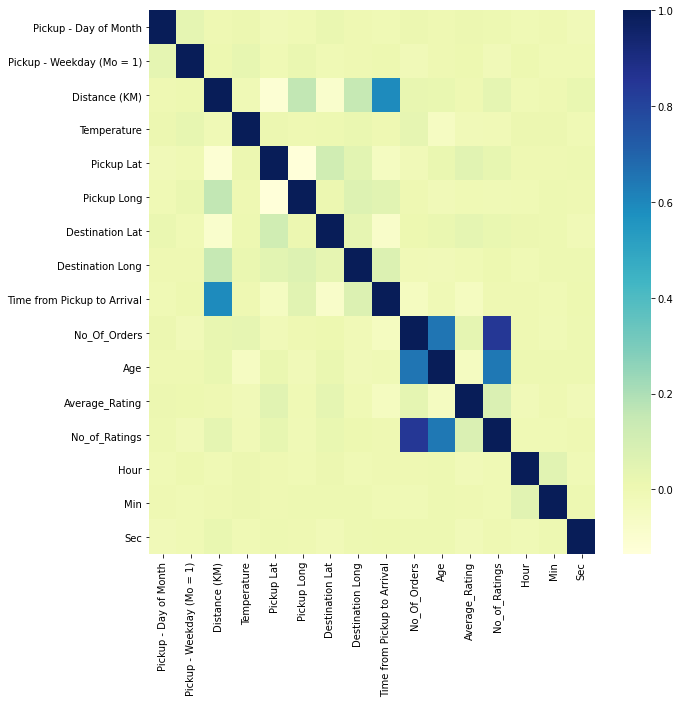

In [77]:
# visualize correlation with a Heatmap
plt.figure(figsize = (10, 10))
g = sns.heatmap(cols, cmap="YlGnBu")


In [78]:
# split the data into X & y
X = train_df.drop(columns='Time from Pickup to Arrival')
y = train_df['Time from Pickup to Arrival']

# print the shape
print("X: {}".format(X.shape))
print("y: {}".format(y.shape))


X: (20265, 20)
y: (20265,)


**Notes and Insights**:


*   Train data consist of 20265 entries and 20 columns
*   ?



## **Splitting the Raw Data**

In [79]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# print the shape
print(X_train.shape)
print(X_test.shape)
print(X_validation.shape)
print(y_train.shape)
print(y_test.shape)
print(y_validation.shape)


(12969, 20)
(4053, 20)
(3243, 20)
(12969,)
(4053,)
(3243,)


## **Model Selection**:

### **Linear Regression Model**:

In [80]:
# create model object and fit X_train
lr = LinearRegression()
lr.fit(X_train, y_train)

# results on test
y_pred_t = lr.predict(X_train)
y_pred_v = lr.predict(X_validation)

# print RMSE score
print('Train RMSE: ', np.sqrt(mean_squared_error(y_train, y_pred_t)))
print('Test RMSE: ', np.sqrt(mean_squared_error(y_validation, y_pred_v)))


Train RMSE:  787.3576318334865
Test RMSE:  773.5911304453602


### **XGBoost Regression Model**:

In [81]:
# create model object and fit X_train
xg_reg = xgb.XGBRegressor()
xg_reg.fit(X_train, y_train)

# results on test
y_pred_t = xg_reg.predict(X_train)
y_pred_v = xg_reg.predict(X_validation)

# print RMSE score
print('Train RMSE: ', np.sqrt(mean_squared_error(y_train, y_pred_t)))
print('Test RMSE: ', np.sqrt(mean_squared_error(y_validation, y_pred_v)))


[04:24:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Train RMSE:  729.3049730690436
Test RMSE:  735.3899646098317


## **Model Tuning**:

### **Bayesian Optimization**

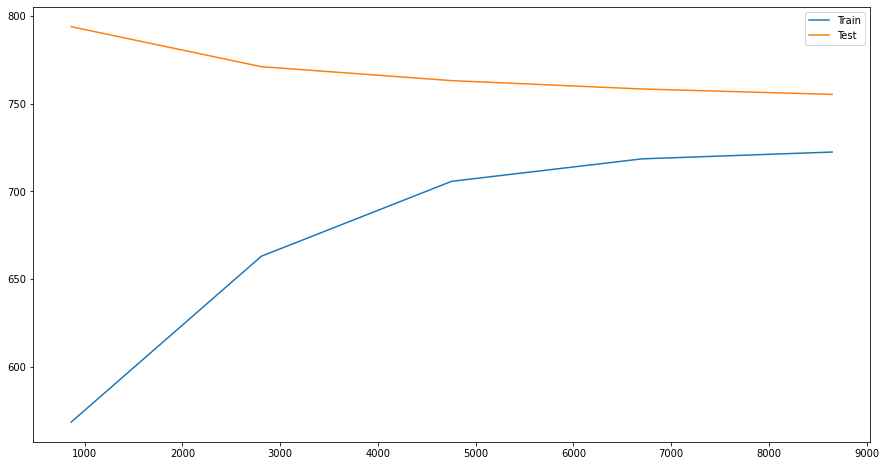

In [82]:
# compute the learning curve
line = learning_curve(xg_reg, X_train, y_train, cv = 3, n_jobs = -1, scoring = 'neg_mean_squared_error') 
train_score = [-line[1][i].mean() for i in range (0, 5)]
test_score = [-line[2][i].mean() for i in range (0, 5)]

# Plot learning curve
fig = plt.figure(figsize = (15, 8))
plt.plot(line[0], np.sqrt(train_score), label = 'Train')
plt.plot(line[0], np.sqrt(test_score), label = 'Test')
plt.legend()


## **Submission**:

### **Data Preparation**:

In [83]:
# drop the 'Vehicle Type' column
test_df = test_df.drop(['Vehicle Type'], axis = 1)

# drop the Precipitation column
test_df = test_df.drop(['Precipitation in millimeters'], axis = 1)

# fill missing values with the mean in the Temperature column
test_df['Temperature'].fillna((test_df['Temperature'].mean()), inplace = True)

# selecting usefull columns only
test_df = test_df.drop(['Order No', 'User Id', 'Placement - Day of Month',
       'Placement - Weekday (Mo = 1)', 'Placement - Time',
       'Confirmation - Day of Month', 'Confirmation - Weekday (Mo = 1)',
       'Confirmation - Time', 'Arrival at Pickup - Day of Month',
       'Arrival at Pickup - Weekday (Mo = 1)', 'Arrival at Pickup - Time', 'Rider Id'], axis=1)

# split the time in 'Pickup - Time' column
pick_df = split_str_time(test_df, 'Pickup - Time')

# join 'test_df' and 'pick_df' on 'Pickup - Time' column
test_df = pd.merge(test_df, pick_df, on = 'Pickup - Time')

# change categorical variables into numeric representation
test_df = pd.get_dummies(test_df, columns = ['Platform Type', 'Personal or Business', 'AM_PM'])

# drop extra dummy variable columns to avoid the dummy variable trap
test_df = test_df.drop(['Platform Type_4', 'Personal or Business_Personal', 'AM_PM_PM'], axis=1)

# visualize test_df
test_df.head()


Pickup - Day of Month  ...  AM_PM_AM
0                     27  ...         0
1                     27  ...         0
2                      7  ...         0
3                      7  ...         0
4                     26  ...         0

[5 rows x 21 columns]

In [0]:
# drop 'Pickup - Time' column
test_df = test_df.drop(['Pickup - Time'], axis=1)


In [90]:
# predict on test
pred = xg_reg.predict(test_df)
#samplesubmission['Time from Pickup to Arrival'] = pred.round()

# visualize samplesubmission
print("{}\n{}".format(len(pred), len(samplesubmission)))


8574
7068


In [89]:
# download csv
pred.to_csv('filename.csv') 
files.download('filename.csv')


AttributeError: ignored